In [5]:
import pandas as pd

In [47]:
import re

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pymorphy2
import razdel


morph = pymorphy2.MorphAnalyzer()

In [3]:
train = pd.read_json('../train.json')
train = train[train.text.str.len() < 10000]
train.shape

(7732, 3)

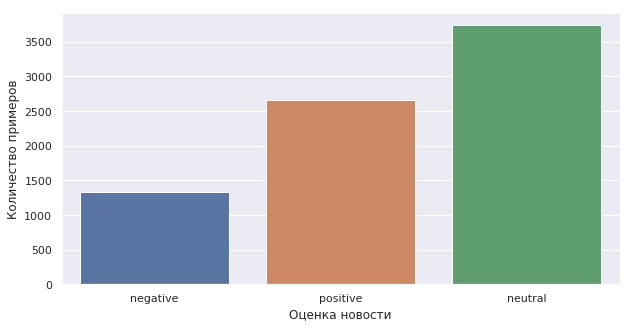

In [26]:
sns.set(style="darkgrid")
plt.figure(figsize=(10, 5))
ax = sns.countplot(x="sentiment", data=train)
ax.set(xlabel='Оценка новости', ylabel='Количество примеров');

In [3]:
from multiprocessing import Pool
from tqdm import tqdm


def _foo(x):
    return ' '.join([
        morph.parse(token.text)[0].normal_form 
        for token in razdel.tokenize(re.sub(r'[^а-ё ]', ' ', x.lower()))
    ])


with Pool(8) as p:
    texts = list(tqdm(p.imap(_foo, train.text.values), total=len(train)))

100%|██████████| 7732/7732 [03:56<00:00, 41.18it/s]


In [4]:
train['text_prep'] = texts

In [6]:
train = pd.read_csv('../train_prep.csv')

In [5]:
negative = train[train.sentiment == 'negative']
positive = train[train.sentiment == 'positive']
neutral = train[train.sentiment == 'neutral']

In [6]:
negative_freq = negative.text_prep.str.split(expand=True).stack().value_counts()
positive_freq = positive.text_prep.str.split(expand=True).stack().value_counts()
neutral_freq = neutral.text_prep.str.split(expand=True).stack().value_counts()

In [7]:
negative_set = set(negative_freq.index)
positive_set = set(positive_freq.index)
neutral_set = set(neutral_freq.index)

In [8]:
negative_words = set(negative_freq.index) - set(positive_freq.index)
positive_words = set(positive_freq.index) - set(negative_freq.index)
neutral_words = set(neutral_freq.index)

In [9]:
print('Плохие слова')
negative_freq[negative_freq.index.isin(negative_words)][:50]

Плохие слова


терентьев           113
акжаркын             83
нацбюро              70
экстраординарный     69
анарбай              59
галим                50
аймагамбет           50
саранский            45
джакуп               41
бахт                 40
лоббирование         38
санкционировать      35
дильрух              33
сарий                33
айтимбет             32
оштрафовать          30
керосин              29
взяточничество       29
дутбаев              27
твориться            27
болашакер            26
махинация            26
самоподжог           24
жанбосынов           24
невиновность         24
арестованный         24
отбывание            24
исправительный       23
халатность           23
выговор              22
санкционирование     21
подзащитный          21
тюремный             21
ффк                  21
возмущаться          20
категорически        20
вирус                20
вернал               20
поймать              20
перепечатка          19
блоха                19
улюкай          

In [10]:
print('Хорошие слова')
positive_freq[positive_freq.index.isin(positive_words)][:50]

Хорошие слова


делегация          156
физкульт           143
мельниченко        121
корабль            121
шёлковый           113
аутизм              80
упражнение          77
ассамблея           71
экспедиция          70
паромный            69
вэтс                65
универсал           65
стандартизация      59
казань              57
баскетбольный       56
берлин              56
курык               55
арабский            53
выпускаться         52
перевалка           52
ибраимов            49
агрохимический      49
коррекционный       48
транскаспийский     47
ента                47
взаимовыгодный      47
водородный          46
эмират              46
аутист              46
цинк                45
манюров             45
ультразвуковой      44
гюзель              44
тихоненко           44
машиностроитель     43
актогай             42
пирс                42
нак                 42
апк                 42
байконур            42
наставник           42
ссуда               41
ярмарка             41
вьетнам    

In [11]:
pos_freq = dict(positive_freq)
neg_freq = dict(negative_freq)
neu_freq = dict(neutral_freq)

In [12]:
def word_sentiment(word):
    #word = morph.parse(word.lower())[0].normal_form
    if word in negative_words:
        neg = neg_freq[word]
        
        if word in neutral_words:
            neu = neg_freq[word]
            
            if neg > neu/2:
                return -neg/2
            if neu > neg:
                return 0
            
        return -neg #-1
        
    if word in positive_words:
        pos = pos_freq[word]
        
        if word in neutral_words:
            neu = neu_freq[word]
            
            if pos > neu/2:
                return pos/2
            if neu > pos:
                return 0
            
        return pos #1
    
    return 0

In [13]:
from multiprocessing import Pool
from tqdm import tqdm


def _foo(x):
    return sum([word_sentiment(w) for w in x.split()])


with Pool(4) as p:
    pred = list(tqdm(p.imap(_foo, train.text_prep.values), total=len(train)))

100%|██████████| 7732/7732 [00:01<00:00, 5764.71it/s]


In [14]:
train['pred'] = pred

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(color_codes=True)

In [13]:
from sklearn.metrics import confusion_matrix

In [17]:
def threshold(x, pos_thres, neg_thres):
    if x > pos_thres:
        return 'positive'
    if x < neg_thres:
        return 'negative'
    return 'neutral'

#train['result'] = train.pred.apply(threshold)

In [18]:
from sklearn.metrics import f1_score

In [19]:
def score(x):
    pos_thres, neg_thres = x
    train['result'] = train.probs.apply(lambda x: threshold(x, pos_thres, neg_thres))
    return f1_score(train.sentiment, train.result, average='macro')

In [20]:
train['probs'] = train.apply(lambda x: x.pred / len(x.text_prep.split()), axis=1)

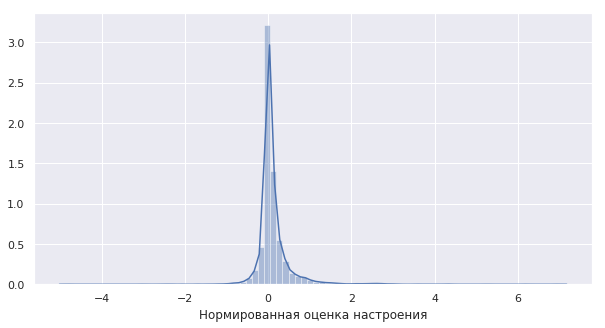

In [21]:
plt.figure(figsize=(10, 5))

ax = sns.distplot(train.probs.values, bins=80)#.set_title('Распределение настроения новостей');
ax.set(xlabel='Нормированная оценка настроения');#№, ylabel='Количество примеров');

In [22]:
from scipy.optimize import minimize

In [291]:
res = minimize(score, [0,-0], method='BFGS', options={'xtol': 1e-8, 'disp': True})

/home/e1four15f/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: OptimizeWarning: Unknown solver options: xtol
  """Entry point for launching an IPython kernel.
/home/e1four15f/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/e1four15f/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/e1four15f/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/e1four15f/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py

/home/e1four15f/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/e1four15f/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/e1four15f/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/e1four15f/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Optimization terminated successfully.
         Current function value: 0.412189
         Iterations: 1
         Function evaluations: 44
         Gradient evaluations: 11


/home/e1four15f/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/e1four15f/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/e1four15f/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/e1four15f/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [292]:
res

      fun: 0.4121893760065604
 hess_inv: array([[1, 0],
       [0, 1]])
      jac: array([0., 0.])
  message: 'Optimization terminated successfully.'
     nfev: 44
      nit: 1
     njev: 11
   status: 0
  success: True
        x: array([0.00000000e+00, 5.12589879e-05])

In [38]:
score([0.1, -0.05])

0.6853966392399009

In [35]:
from sklearn.metrics import classification_report

In [40]:
print(classification_report(train.sentiment.values, train.result.values))

              precision    recall  f1-score   support

    negative       0.73      0.68      0.71      1337
     neutral       0.66      0.72      0.69      3734
    positive       0.70      0.63      0.66      2661

    accuracy                           0.68      7732
   macro avg       0.70      0.68      0.69      7732
weighted avg       0.68      0.68      0.68      7732



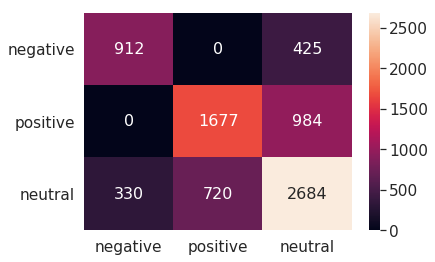

In [39]:
labels = train.sentiment.unique()
array = confusion_matrix(train.sentiment, train.result, labels)
df_cm = pd.DataFrame(array, labels, labels)
                  
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='.5g');
plt.yticks(rotation=0);

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline, FeatureUnion

In [23]:
clf = Pipeline([
    ('tfidf', FeatureUnion([
        ('word', TfidfVectorizer(ngram_range=(1, 2), max_features=20000)),
        ('char', TfidfVectorizer(analyzer='char', ngram_range=(3, 5), max_features=10000))
    ])),
    ('clf', LogisticRegression(n_jobs=4, solver='lbfgs', multi_class='auto')),
])
clf = clf.fit(train.text_prep.values, train.sentiment.values)

In [16]:
labels = train.sentiment.unique()
array = confusion_matrix(train.sentiment, clf.predict(train.text.values), labels)
df_cm = pd.DataFrame(array, labels, labels)
                  
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='.5g');
plt.yticks(rotation=0);

NameError: name 'sns' is not defined

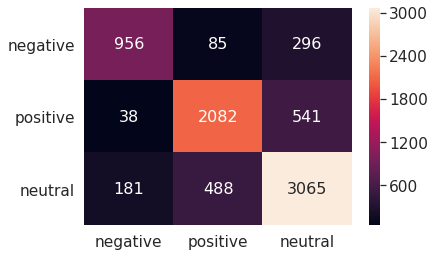

In [20]:
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='.5g');
plt.yticks(rotation=0);

In [27]:
pred = clf.predict(train.text.values)

In [28]:
print(classification_report(train.sentiment.values, pred))

NameError: name 'classification_report' is not defined

In [24]:
import eli5

'Досудебное расследование по факту покупки ЕНПФ пакета облигаций ТОО "Бузгул Аурум" было начато по инициативе Национального банка РК, сообщил директор департамента защиты прав потребителей и финансовых услуг Нацбанка Казахстана Александр Терентьев.\n"Основанием для досудебного расследования стало обращение Национального банка, письмо от 25 ноября 2016 года. Было обращение Национального банка в правоохранительные органы. Нам эта сделка показалась сомнительной, недостаточно корректной, поэтому Нацбанк 25 ноября 2016 года обратился в правоохранительные органы. Это то, что я могу озвучить на сегодня. Идёт следствие, проводится проверка", – сказал Терентьев.\n28 декабря в Нацбанке заявили, что не знают, что стало основанием для проверки ЕНПФ.\n23 декабря факт проведения проверки в АО "Единый накопительный пенсионный фонд" подтвердился. Пресс-служба Национального банка сообщила, что проверку проводят по операциям, совершённым АО "ЕНПФ" в отношении инвестирования собственных активов.\nТакже в

In [ ]:
clf.predictd

In [34]:
eli5.explain_prediction(clf, train.text_prep.values[0])

Explanation(estimator="Pipeline(memory=None,\n         steps=[('tfidf',\n                 FeatureUnion(n_jobs=None,\n                              transformer_list=[('word',\n                                                 TfidfVectorizer(analyzer='word',\n                                                                 binary=False,\n                                                                 decode_error='strict',\n                                                                 dtype=<class 'numpy.float64'>,\n                                                                 encoding='utf-8',\n                                                                 input='content',\n                                                                 lowercase=True,\n                                                                 max_df=1.0,\n                                                                 max_features=20000,\n                                                                 min_df=1,\n                                                                 ngram_range=(1,\n                                                                              2),\n                                                                 norm='l2',\n                                                                 preprocessor=None,\n                                                                 smooth_idf=True,\n                                                                 stop_words=None,\n                                                                 s...\n                                                                 token_pattern='(?u)\\\\b\\\\w\\\\w+\\\\b',\n                                                                 tokenizer=None,\n                                                                 use_idf=True,\n                                                                 vocabulary=None))],\n                              transformer_weights=None, verbose=False)),\n                ('clf',\n                 LogisticRegression(C=1.0, class_weight=None, dual=False,\n                                    fit_intercept=True, intercept_scaling=1,\n                                    l1_ratio=None, max_iter=100,\n                                    multi_class='auto', n_jobs=4, penalty='l2',\n                                    random_state=None, solver='lbfgs',\n                                    tol=0.0001, verbose=0, warm_start=False))],\n         verbose=False)", description=None, error="estimator Pipeline(memory=None,\n         steps=[('tfidf',\n                 FeatureUnion(n_jobs=None,\n                              transformer_list=[('word',\n                                                 TfidfVectorizer(analyzer='word',\n                                                                 binary=False,\n                                                                 decode_error='strict',\n                                                                 dtype=<class 'numpy.float64'>,\n                                                                 encoding='utf-8',\n                                                                 input='content',\n                                                                 lowercase=True,\n                                                                 max_df=1.0,\n                                                                 max_features=20000,\n                                                                 min_df=1,\n                                                                 ngram_range=(1,\n                                                                              2),\n                                                                 norm='l2',\n                                                                 preprocessor=None,\n                                                                 smooth_idf=True,\n                                                     

In [57]:
zel = [\
'''
В Зеленограде водитель «Мерседеса» совершил наезд на мать с 5-летней девочкой.

Дорожный инцидент произошел в среду, 25 декабря, около 15:00 на улице Каменке, напротив детской поликлиники (корпус 1513). По данным зеленоградского отдела ГИБДД, женщина с ребенком переходила дорогу по нерегулируемому пешеходному переходу из 18-го микрорайона в 15-й, а автомобиль двигался от улицы Логвиненко.

«Услышала удар, когда подняла голову, увидела, как женщина поднимает ребенка [с проезжей части] — он был перед автомобилем», — рассказала Инфопорталу очевидец последствий ДТП. По словам свидетельницы, мать сразу же повела девочку в поликлинику. Водитель «Мерседеса» остался на месте происшествия.

Пешеходы избежали серьезных травм. После осмотра в травмпункте девочку с мамой отпустили домой.
В 2019 году в Зеленограде наблюдается всплеск смертности среди пешеходов. После трагического ДТП на улице Каменке в начале декабря, унесшего жизни двух человек — 62-летней женщины и ее 5-летней внучки, в ГИБДД предложили оборудовать ряд нерегулируемых переходов, в том числе «зебру» у поликлиники в 15-м микрорайоне, светофорами с кнопками вызова пешеходной фазы. Это предложение уже поддержали в префектуре, но его еще нужно согласовать с Москвой.
''',
'''
В Зеленограде двух молодых людей приговорили к ограничению свободы. Они устроили дебош на детской площадке и разрисовали подъезд непристойными рисунками.

Первый акт вандализма М. Саулин и Е. Васильев совершили 26 ноября 2018 года в пятом часу ночи в одном из дворов района Старое Крюково. Как говорится в приговоре, они ногами повредили металлическую мусорную урну и сломали информационную табличку «Детская площадка». Полицию вызвал житель соседнего дома, наблюдавший за происходящим со своего балкона. Вандалов задержали на месте происшествия. Ущерб, причиненный управляющей компании «Жилищник», составил 3 543 рубля.

Спустя почти три недели, в ночь на 14 декабря, Саулин и Васильев вновь совершили преступление — уже в районе Силино. Они разрисовали аэрозольными баллончиками входные группы двух подъездов жилого дома, стены первого этажа, двери электрощитовых и мусороприемников. Хулиганы нанесли синими, белыми и черными красками непристойные рисунки, свастику и надписи с нецензурными словами. Злоумышленников обнаружил на лестничной площадке местный житель, возвращавшийся домой. Он позвонил в полицию и встретил экипаж на улице. В момент прибытия стражей порядка Саулин спал, сидя на ступеньке, а Васильев стоял рядом. Их задержали. На отмывку стен «Жилищник» потратил 76 тысяч рублей.
Согласно материалам дела, в обоих эпизодах молодые люди находились в состоянии алкогольного опьянения. Суд приговорил Саулина и Васильева к ограничению свободы на срок 1 год 1 месяц, в течение которого им запрещено выходить на улицу с 22:00 до 6:00, посещать увеселительные заведения, где продают спиртное, и массовые мероприятия, менять место жительства без согласия уголовно-исполнительной инспекции. Они также обязаны выплатить «Жилищнику» 40 тысяч рублей (ранее Васильев уже частично возместил ущерб).

В качестве смягчающих наказание обстоятельств суд признал молодой возраст обвиняемых, их раскаяние и состояние здоровья Саулина.

Добавим, что человек с такой же фамилией и инициалами, как у Саулина, в феврале 2018 года представал перед судом в Зеленограде по делу о краже, совершенной группой лиц по предварительному сговору. На тот момент он был несовершеннолетним, и суд прекратил уголовное преследование, применив к обвиняемому принудительную меру воспитательного воздействия.
''',
'''
С 1 по 31 января 2020 года водители легковых автомобилей с транспондерами трассы М11 смогут бесплатно ездить по участку Москва–Солнечногорск с 1 часа ночи до 6 часов утра.

Об этом сообщили в «Северо-Западной концессионной компании». При проезде сразу по нескольким участкам М11, например, от Москвы до Клина, автомобилисту придется заплатить только за участок от Солнечногорска. Оформить транспондер М11 можно в офисе обслуживания клиентов на 21-м километре трассы (7-й километр от МКАД).

Кроме того, в новогодние праздники, с 1 по 8 января, на головном участке платной трассы будут действовать специальные тарифы. Ознакомиться с ними можно здесь.
Напомним, такую же акцию оператор участка Москва–Солнечногорск проводил и прошлой зимой — тогда она длилась три месяца.
''',
'''
В Зеленограде 13-летний школьник попал под машину на нерегулируемом пешеходном переходе.

Дорожный инцидент произошел в понедельник, 23 декабря, около 15:00 на улице Болдов ручей напротив корпуса 1117. Как сообщили в зеленоградском отделе ГИБДД, водитель автомобиля Hyundai Solaris, 47-летний житель Подмосковья, следуя от Филаретовской улицы, сбил мальчика, который переходил дорогу по «зебре» слева направо по ходу движения машины, то есть от леса к дому. Пострадавшего ребенка доставили в московскую больницу.
Нерегулируемый пешеходный переход в этом месте появился совсем недавно — минувшей осенью. Решение об обустройстве «зебры» между лесопарком и корпусом 1117 было принято профильной комиссией префектуры еще в 2015 году.
''',
'''
В Зеленограде водитель «Яндекс.Такси» уснул за рулем в ожидании зеленого сигнала светофора.

Видео с задремавшим таксистом опубликовало инстаграм-сообщество zelenogram. Как сообщается в подписи к ролику, это произошло перед перекрестком у торгового комплекса «Панфиловский». Водитель Kia Cerato остановился в среднем ряду и, пока ждал разрешающего сигнала светофора, уснул, опустив голову вниз. Стоявшие перед ним машины уже проехали перекресток, а он остался на месте, заблокировав путь другим водителям. В итоге спящего таксиста разбудил один из автомобилистов — он подошел к машине и постучал в окно.
''',
'''
Зеленоградский спортсмен принял участие в очередном этапе Кубка мира по биатлону.

Третий в сезоне этап самой престижной серии соревнований в мировом биатлоне прошел в минувший уикенд во французском Анси. Его результаты опубликованы на сайте Международного союза биатлонистов, а гонки были показаны в прямом эфире на канале «Матч». Матвей Елисеев принял участие во всех трех стартах мужской части программы.

В пятничном спринте зеленоградец с одним промахом показал 28-й результат, уступив 1 минуту 16 секунд победителю — Бенедикту Долю из Германии. На следующий день Елисеев промахнулся лишь раз на четырех огневых рубежах в гонке преследования, но не смог улучшить свой результат, и финишировал — 30-м. В воскресенье воспитанник спортшколы №111 принял участие в масс-старте, в который квалифицировались лучшие 30 биатлонистов сезона, но несмотря на «чистую» стрельбу, финишировал лишь 29-м. В интервью после гонки Елисеев объяснил неудачу неправильным выбором лыж для сложных погодных условий (старт проходил под дождем) и отметил накопившуюся усталость.
После трех этапов Кубка мира зеленоградец занимает 12-е место в общем зачете соревнований. Лучший из россиян — Александр Логинов — 6-й. Кроме того, Елисеев стал одним из двух членов сборной России, которые выполнили показатели, соответствующие критериям отбора для участия в январских этапах Кубка мира.
''',
'''
Жительница Зеленограда заключила мировое соглашение с торговым центром по делу о выплате компенсации за полученную травму.

Как утверждалось в исковом заявлении, 25 февраля 2019 года около 22 часов при выходе из ТЦ «Столица» женщина поскользнулась на покрытой льдом лестнице. Пострадавшая подала в суд на компанию, управляющую торговым центром, и коммерческую организацию, осуществляющую уборку территории, требуя полмиллиона рублей в счет возмещения морального вреда и 48 тысяч рублей в качестве компенсации материального ущерба и судебных расходов.

В итоге стороны пришли к мировому соглашению. Согласно определению Зеленоградского районного суда, за причиненный вред здоровью «Столица» заплатит женщине 140 тысяч рублей, а второй ответчик — 90 тысяч рублей.
''',
'''
На встрече в управе местные жители выступили против превращения регбийного поля в стадион с трибунами и крытым манежем.

Презентация концепции благоустройства регбийного поля, реализация которого намечена на 2021 год, состоялась в среду, 18 декабря, в управе района Савелки. Ее провел представитель проектной организации «Горметпроект» Вячеслав Ли. Как следует из презентации, площадь благоустраиваемого участка между корпусом 521 и Ленинградским шоссе, рядом с парком «Ровесник», составляет около 20 тысяч кв. метров. Существующее на этом участке регбийное поле предполагается развернуть на 90 градусов, «торцом» к Ленинградке, чтобы иметь возможность разместить здесь и другие объекты. Поле размером 131х78 метров (игровая часть, выделенная разметкой, будет несколько меньше) получит естественное покрытие в виде рулонного газона, устойчивого к вытаптыванию. При необходимости после игр можно будет менять фрагменты газона, чтобы он всегда сохранял свои качества для проведения спортивных мероприятий, отметил проектировщик.

Вокруг поля сделают невысокое ограждение и поставят 14-метровые мачты освещения, которое будет осуществляться оборудованием с регулируемым светопотоком. Со стороны парка «Ровесник» вдоль поля установят трибуны из пяти секторов общей вместимостью 260 человек и модули контейнерного типа для размещения раздевалок на шесть команд и прочих административно-бытовых помещений. При этом трибуны будут располагаться на кровле контейнеров, что создаст лучший обзор для зрителей, подчеркнул Вячеслав Ли. Судя по изображениям в презентации, с двух сторон от поля также появятся большие табло.

Рядом с основным регбийным полем предполагается разместить манеж с искусственным покрытием площадки размером 60х40 метров. Этот объект, по словам проектировщика, можно будет использовать для занятий мини-футболом, мини-регби и теннисом. Манеж будет представлять собой арочную быстровозводимую конструкцию с тентовым покрытием. Кроме того, в составе комплекса предполагается оборудовать детскую площадку, площадку для занятий воркаутом и служебную парковку на 22 автомобиля, у въезда на которую расположится КПП со шлагбаумом.
Сразу после выступления докладчика слово взял присутствовавший на встрече житель корпуса 519, который высказался категорически против проекта. Его мнение поддержали возгласами еще несколько человек, при этом никто из присутствовавших на собрании местных жителей не возразил против данного мнения. Основная претензия мужчины к проекту заключалась в отсутствии достаточно вместительной парковки. «Каждый второй приедет на машине. Парковаться они будут у нас во дворах. […] Мы здесь живем, и нам это поле не нужно вообще. […] Оно было в таком виде: автобус приезжал туда раз в неделю с командами — и отлично. Пусть оно так и остается. […] Или тогда стройте поле и одновременно с этим полем стройте шлагбаумы, чтобы ни одна чужая машина не заехала к нам во дворы. […] К нам уже приезжают на нашу хоккейную коробку, будут теперь приезжать на теннисный корт и будут приезжать еще сюда. Значит, жизни у нас не будет! Будет такая же фигня, как в 9-м районе, как вот сейчас в 16-м районе, когда людям жить не дают — построили эту площадку фестивальную и так далее. […] Есть стадион "Элион" — заберите его у частников, мы знаем каких, мы знаем, чей это стадион — постройте там регбийное поле. Там полно места. Шалманы эти к чертям собачьим уберите. А это просто ад какой-то!» — сказал местный житель. Глава управы Андрей Макшанцев прокомментировал это выступление так: «Это как раз проблема: кому-то нужно, кому-то не нужно».
Поле рядом с 5-м микрорайоном используется для игры в регби и организованных тренировок по этому виду спорта как минимум с середины 2000-х годов. В 2009 году на этом месте собирались построить «народный гараж», однако после протестов регбистов, у которых на тот момент не было ни одной благоустроенной площадки для игр в Зеленограде, власти отказались от этих намерений. В 2011 году это площадка предлагалась для размещения ФОКа, но этот проект не был реализован. Как минимум с 2012 года известно о планах властей превратить регбийное поле в стадион, построив там трибуны. В 2013 году намерения разместить здесь более масштабный спортивный комплекс подтверждали в Москомархитектуре, но в итоге ничего этого не случилось.

Несколько месяцев назад первый зампрефекта Алексей Михальченков сообщил о перспективе строительства в Зеленограде второго регбийного стадиона с большими трибунами. При этом место предполагаемой застройки он не назвал, а о благоустройстве регбийного поля в 5-м микрорайоне говорил как об отдельном проекте. Отметим, что благоустройство этого поля с установкой ограждения, освещения, трибун и раздевалки входило в предвыборную программу избранного в 2019 году депутата Мосгордумы от Зеленограда Андрея Титова. При этом о выделении средств на разработку проектно-сметной документации по реконструкции объекта стало известно за несколько месяцев до формирования данной программы.
''',
'''
В зеленоградской горбольнице рассказали историю спасения девушки, которая несколько дней находилась между жизнью и смертью после серьезного ДТП.

Историю 19-летней Анастасии Парфировой пресс-служба медицинского учреждения опубликовала в середине декабря. Сам инцидент, в котором она пострадала, произошел двумя месяцами ранее. Как рассказал Инфопорталу источник в экстренных службах, ДТП случилось ночью 7 октября на Ленинградском шоссе в районе Черной Грязи. Машина, в которой в качестве пассажира на переднем сиденье находилась Анастасия, ударилась в отбойник.

Пострадавшую доставили в травмоцентр зеленоградской больницы в тяжелейшем состоянии. «Сразу же подключились все необходимые специалисты, провели КТ, обработали раны. Дежурный врач вызвал заведующего отделением травматологии и ортопедии Алексея Мыльникова. Алексей Васильевич приехал незамедлительно. Результаты компьютерной томографии показали — трансаллярный перелом крестца, открытый оскольчатый перелом крыла правой подвздошной кости таза со смещением, перелом лонных и седалищных костей таза со смещением, разрыв крестцово-подвздошного сочленения (КПС) справа», — говорится в сообщении клиники.

Перелом тазовых костей — наиболее опасное и тяжелое повреждение опорно-двигательного аппарата, пояснили медики. Травма сопровождается обильным кровотечением из обломков и мягких тканей, травматическим шоком, который возникает на фоне кровопотери и интенсивного болевого синдрома. В случае, когда перелом открытый, риск для жизни значительно возрастает. Жизнь Анастасии действительно была под угрозой — по экстренным показаниям ей провели первую операцию: первичную хирургическую обработку ран и стабилизацию переломов таза в надацетабулярном аппарате внешней фиксации. Состояние девушки оставалось тяжелым из-за сильной потери крови и болевого синдрома. Трое суток специалисты боролись за ее жизнь в отделении анестезиологии-реанимации. В результате интенсивной противошоковой, гемотрансфузионной, антибактериальной и антикоагулянтной терапии состояние пациентки, наконец, было стабилизировано. На четвертые сутки после аварии врачи провели вторую операцию: окончательную реконструкцию тазового кольца и комбинированный остеосинтез (внутреннюю фиксацию).
Операция была проведена совместно с научным сотрудником отделения множественной и сочетанной травмы НИИ скорой помощи имени Склифосовского Никитой Заднепровским — автором методики внутрикостной фиксации переломов лонной кости штифтом с блокированием. Учитывая уникальность метода, в операционной с целью обучения присутствовали врачи из Индии и Тюменской области. Как правило, пострадавшие с такими травмами прикованы к кровати несколько месяцев. Но использованная в данном случае методика благодаря надежной фиксации отломков позволяет практически сразу купировать болевой синдром в области перелома лонной кости и активизировать пациента в максимально короткие сроки. Уже на второй день после операции Анастасия начала садиться и вставать. Передвигалась поначалу при помощи ходунков. Но главное — она могла ходить и практически не испытывала боли. Девушка была выписана домой. Дальнейшее лечение и контроль за ее состоянием велись амбулаторно.
Недавно Анастасия приезжала в больницу на контрольный осмотр. Врачи отметили хорошее восстановление двигательных функций, начальные признаки сращения переломов, полный объем движений в суставах, отсутствие болевого синдрома. Она уже ходит самостоятельно без каких-либо вспомогательных средств, может приседать и практически вернулась к обычному ритму жизни.
Травматологический центр первого уровня был создан на базе больницы в Зеленограде в марте текущего года. С пациентами здесь работает мультидисциплинарная бригада, в которую входят анестезиологи-реаниматологи, хирурги, травматологи-ортопеды, специалисты диагностических служб, по показаниям привлекаются другие специалисты. По словам главврача больницы имени Кончаловского Олега Гриднева, ежегодно в стационар медучреждения поступает порядка 150 пострадавших с «травмой высокой энергии». «В основном это следствие ДТП и падений с высоты. В травмоцентре им оказывают специализированную и высокотехнологичную помощь в полном объеме, начиная с приемного отделения и заканчивая первым этапом реабилитации. Слаженная работа всех подразделений позволяет нам достигать хороших результатов при лечении этой категории больных», — сообщил Гриднев.
''',
'''
   Окружная градостроительная комиссия, возглавляемая префектом Анатолием Смирновым, одобрила проект планировки жилого комплекса, который появится на месте сносимых «хрущевок» у станции Крюково.

Соответствующие заключения по итогам слушаний опубликованы на сайте префектуры Зеленограда. Теперь проект реновации будет передан в Москву для дальнейшего согласования и утверждения.

Формально по 19-му микрорайону проводились двое слушаний одновременно — по проекту планировки и по проекту внесения изменений в правила землепользования и застройки (ПЗЗ). Общее собрание состоялось 29 октября в школе в 23-м микрорайоне. Количество участников и поступивших отзывов подсчитывали по каждым слушаниям отдельно (поэтому на сайте префектуры опубликованы два пакета документов). Как указано в протоколах, подавляющее большинство — больше 450 человек — одобрили проект реновации. При этом комиссия не стала учитывать ксерокопии 30 листов с 211 подписями, так как не смогла установить их подлинность. Эти отзывы представила участница слушаний Элла Анфимова, критиковавшая проект.

Всем, кто выступал против уплотнения застройки 19-го микрорайона и высказывал недовольство малым количеством парковочных мест, в градостроительной комиссии ответили такими тезисами: расчетная плотность застройки квартала реновации (13,7 тыс. кв. м / га) соответствует нормам; высота застройки составляет 7–14 этажей с отдельными акцентами до 23 этажей, что соответствует архитектурному стилю района Крюково и не противоречит действующим градостроительным нормам; проектом предусмотрено максимальное размещение наземных парковок вне дворовых пространств, все жилые дома расположены в радиусе не более 500 метров от многоуровневых парковок.

О том, как проходили публичные слушания, Инфопортал подробно писал здесь.
Напомним, на месте 23 «хрущевок» в 19-м микрорайоне собираются построить 22 жилых дома высотой от 7 до 23 этажей с двумя подземными гаражами на 104 места. Помимо жилья там планируют построить детскую поликлинику на 320 посещений в смену (рядом со школой №1912 между Крюковской эстакадой и 18-м микрорайоном), два детских сада на 350 и 100 мест, школу на 600 мест со стадионом, двухэтажный ФОК с бассейном, два многоуровневых паркинга на 300 и 620 машин, общественно-деловой центр, культурный центр, два объекта торговли и объект общепита. Реконструкция микрорайона предполагает расширение проезжей части Заводской улицы (с 10,5 до 15 метров), Советской улицы (с 6 до 11 метров) и улицы 1 Мая (с 6 до 9 метров), открытие двух новых автобусных остановок на Заводской улице и обустройство велодорожки вдоль Георгиевского проспекта, улицы Летчицы Тарасовой и улицы 1 Мая. Траекторию Заводской улицы собираются изменить, ликвидировав перекресток с улицей Радио у «старого» моста через ОЖД.

Вместе с «хрущевками» снесут здание ГИБДД, недострой ФГУП ИППМ РАН, магазин мебели (Заводская улица, дом 18, строение 11), часть зданий лесоторговой базы (Овражная улица, дом 17а, строения 2 и 3), производственное здание (улица Радио, дом 23, строение 9), склад (Заводская улица, дом 1) и двухэтажный кирпичный дом на улице 1 Мая, за сохранение которого боролись местные краеведы, но власти Москвы не признали его памятником истории.

Под снос не попадают 16-этажный корпус 1925 (в народе — «цыганская башня»), 12 частных домовладений, три нежилых дома (высотой 2–3 этажа) на улице 1 Мая, две нежилые двухэтажки на Заводской улице, реабилитационный центр для инвалидов «Ремесла» и здание МФЮА.
'''
]
       

In [58]:
for i in zel:
    print(len(i))

1237
2285
771
731
605
1363
763
4953
4361
3464


In [75]:
links = [
    'https://www.netall.ru/society/news/1136381.html'
]

for i in links:
    print('\\footnote{\href{' + i + '}{' + i + '}}')

\footnote{\href{https://www.netall.ru/society/news/1136381.html}{https://www.netall.ru/society/news/1136381.html}}


In [ ]:
\footnote{\href{}{
      https://github.com/e1four15f/math-modeling-institute
                                                         }}

In [59]:
def _foo(x):
    return ' '.join([
        morph.parse(token.text)[0].normal_form 
        for token in razdel.tokenize(re.sub(r'[^а-ё ]', ' ', x.lower()))
    ])

In [60]:
zel

['\nВ Зеленограде водитель «Мерседеса» совершил наезд на мать с 5-летней девочкой.\n\nДорожный инцидент произошел в среду, 25 декабря, около 15:00 на улице Каменке, напротив детской поликлиники (корпус 1513). По данным зеленоградского отдела ГИБДД, женщина с ребенком переходила дорогу по нерегулируемому пешеходному переходу из 18-го микрорайона в 15-й, а автомобиль двигался от улицы Логвиненко.\n\n«Услышала удар, когда подняла голову, увидела, как женщина поднимает ребенка [с проезжей части] — он был перед автомобилем», — рассказала Инфопорталу очевидец последствий ДТП. По словам свидетельницы, мать сразу же повела девочку в поликлинику. Водитель «Мерседеса» остался на месте происшествия.\n\nПешеходы избежали серьезных травм. После осмотра в травмпункте девочку с мамой отпустили домой.\nВ 2019 году в Зеленограде наблюдается всплеск смертности среди пешеходов. После трагического ДТП на улице Каменке в начале декабря, унесшего жизни двух человек — 62-летней женщины и ее 5-летней внучки, 

In [61]:
zel_prep = list(map(_foo, zel))

In [62]:
preds = clf.predict(zel_prep)

In [63]:
preds

array(['neutral', 'negative', 'neutral', 'neutral', 'neutral', 'positive',
       'negative', 'neutral', 'neutral', 'neutral'], dtype=object)